# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 6.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  U

# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

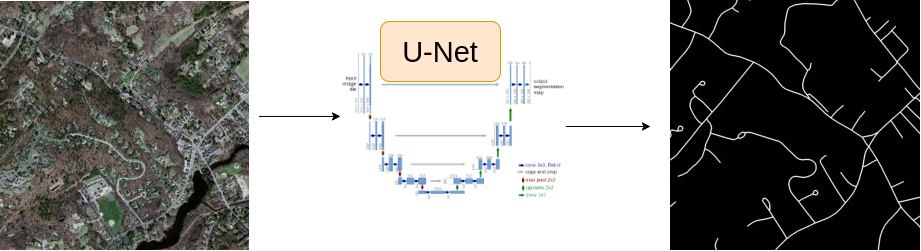

# Download Subset Dataset

In [2]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411
Receiving objects: 100% (411/411), 851.74 MiB | 34.17 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [31]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [6]:
csv_file = "/content/Road_seg_dataset/train.csv"
data_dir = "/content/Road_seg_dataset/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = 20
learning_rate = 0.003
batch_size = 8
img_size = 512

encoder = "timm-efficientnet-b0"
weights = "imagenet"

In [7]:
df = pd.read_csv(csv_file)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [8]:
index = 15

image_path = data_dir + df.iloc[index].images
mask_path = data_dir + df.iloc[index].masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255

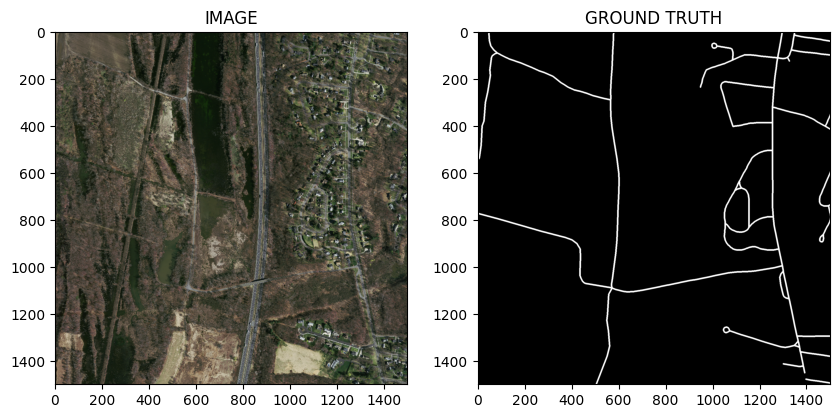

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [10]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [11]:
import albumentations as alb

In [12]:
def get_train_augs():
  return alb.Compose([
      alb.Resize(img_size, img_size),
      alb.HorizontalFlip(p=0.5),
      alb.VerticalFlip(p=0.5)
  ])

def get_val_augs():
  return alb.Compose([
      alb.Resize(img_size, img_size)
  ])

# Task 4 : Create Custom Dataset

In [13]:
from torch.utils.data import Dataset

In [14]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    image_path = data_dir + df.iloc[index].images
    mask_path = data_dir + df.iloc[index].masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #(height, width, channel)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=-1) #(height, width, channel)

    if self.augmentations:
      aug = self.augmentations(image=image, mask=mask)
      image = aug["image"] #(height, width, channel)
      mask = aug["mask"] #(height, width, channel)

    image = np.transpose(image, (2, 0, 1)).astype(np.float32) #(channel, height, width)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32) #(channel, height, width)

    image = torch.Tensor(image) / 255
    mask = torch.round(torch.Tensor(mask) / 255)

    return image, mask

In [15]:
trainset = SegmentationDataset(train, get_train_augs())
valset = SegmentationDataset(test, get_val_augs())

In [16]:
print(f"Size of trainset: {len(trainset)}")
print(f"Size of valset: {len(valset)}")

Size of trainset: 159
Size of valset: 40


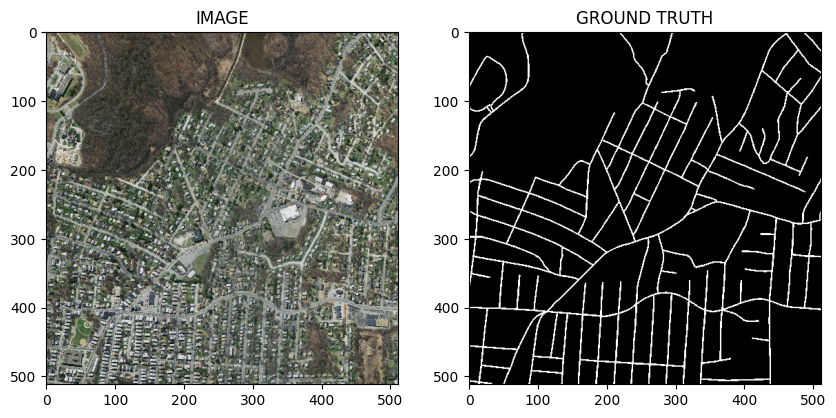

In [17]:
idx = 21

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [18]:
from torch.utils.data import DataLoader

In [19]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size)

In [20]:
print(f"Total number of batches in trainloader: {len(trainloader)}")
print(f"Total number of batches in valloader: {len(valloader)}")

Total number of batches in trainloader: 20
Total number of batches in valloader: 5


In [21]:
for images, masks in trainloader:
  print(f"Shape of images: {images.shape}")
  print(f"Shape of masks: {masks.shape}")
  break

#shape format -> [batch, channel, height, width]

Shape of images: torch.Size([8, 3, 512, 512])
Shape of masks: torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [22]:
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.losses as DiceLoss

import torch.nn as nn

In [23]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name=encoder,
        encoder_weights=weights,
        in_channels=3,
        classes=1,
        activation = None
    )

  def forward(self, images, masks=None):
    logits = self.backbone(images)

    if masks!=None:
      loss1 = DiceLoss.DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2
    return logits

In [24]:
model = SegmentationModel()
model.to(device);

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 170MB/s]


# Task 7 : Create Train and Validation Function

In [25]:
def train_fn(data_loader, model, optimizer):
  model.train() #TURN ON dropout, batchnorm etc.

  total_loss = 0

  for images, masks in tqdm(data_loader):
    images = images.to(device)
    masks = masks.to(device)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  return total_loss/len(data_loader)

In [32]:
from functools import total_ordering
def eval_fn(data_loader, model):
  model.eval() #TURN OFF dropout, batchnorm etc.

  total_loss = 0

  with torch.no_grad():

    for images, masks in tqdm(data_loader):
      images = images.to(device)
      masks = masks.to(device)

      logits, loss = model(images, masks)
      total_loss += loss.item()

    return total_loss/len(data_loader)

# Task 8 : Train Model

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [34]:
best_loss = np.Inf

for i in range(epochs):
  train_loss = train_fn(trainloader, model, optimizer)
  val_loss = eval_fn(valloader, model)

  if val_loss < best_loss:
    torch.save(model.state_dict(),"best-model.pt")

100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


# Task 9 : Inference

In [43]:
idx = 13

model.load_state_dict(torch.load("best-model.pt"))
image, mask = valset[idx]

logits_mask = model(image.to(device).unsqueeze(0)) #(c, h, w) -> (batch, c, h, w)
pred_mask = torch.sigmoid(logits_mask) # applying sigmoid actiation on logits
pred_mask = (pred_mask > 0.5) * 1

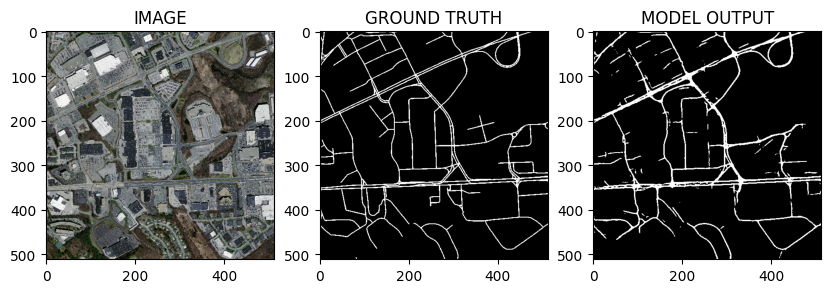

In [44]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0)) #removing batch axis